# Spam/Ham Classification
## Feature Engineering, Logistic Regression, Cross Validation


# Part I - Initial Analysis

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading in the Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Labeled training dataset contains 8348 labeled examples, and the test set contains 1000 unlabeled examples.



In [3]:
original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

Using version already downloaded: Sun Apr 14 12:07:15 2019
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Sun Apr 14 12:07:16 2019
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


First, let's check if our data contains any missing values.

In [4]:
original_training_data.isna().sum()

id         0
subject    6
email      0
spam       0
dtype: int64

In [5]:
original_training_data = original_training_data.replace(np.nan, '', regex=True)

In [6]:
original_training_data.isna().sum()

id         0
subject    0
email      0
spam       0
dtype: int64

The text of the first ham and the first spam email in the original training set.


In [8]:
first_ham = original_training_data[original_training_data['spam']==0]['email'].head(1).values[0]
first_spam = original_training_data[original_training_data['spam']==1]['email'].head(1).values[0]
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



The first most obvious difference is the presence of html tags in the Spam Email. This shows that this particular email was very well formatted. The Ham email also mentions a name and a thank you note at the end, representing an actual indiviual has conjured the email. 

## Training Validation Split
The training data we downloaded is all the data we have available for both training models and **validating** the models that we train.  We therefore need to split the training data into separate training and validation datsets. 

In [10]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

# Basic Feature Engineering



In [11]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    x = []
    for j in texts:
        bag_vector = []
        for w in words:
            bag_vector.append(int(w in j))
                    
        x.append(bag_vector)
        
    indicator_array = np.array(x)
    return indicator_array

# Basic EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.


In [13]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has some words column and a type column. You can think of each row is a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stoed in the value column"))
display(df.melt("type"))

> Our Original DataFrame has some words column and a type column. You can think of each row is a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stoed in the value column

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


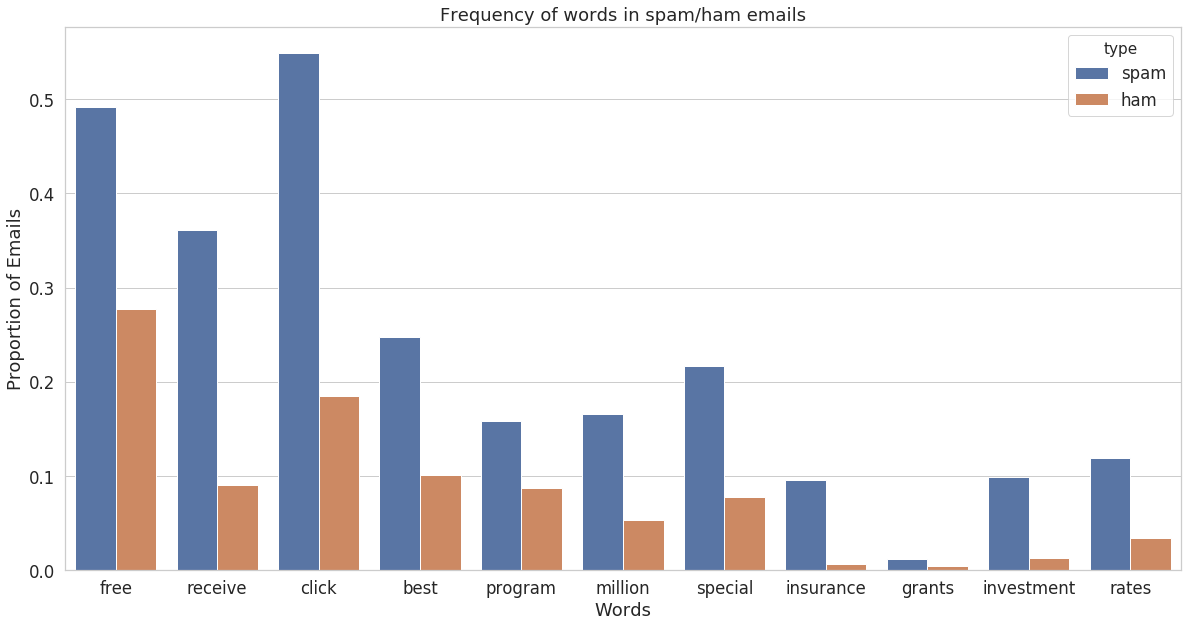

In [14]:
# Let us check the most frequent words in our entire email column.
# This is in accordance to Zipf's Law

freq_spam = pd.Series(' '.join(train[train['spam']==1]['email']).split()).value_counts()[:]
freq_ham = pd.Series(' '.join(train[train['spam']==0]['email']).split()).value_counts()[:]

freq = pd.DataFrame()
freq['spam'] = freq_spam
freq['ham'] = freq_ham
freq['diff'] = (freq['spam'] - freq['ham']).abs()
freq.sort_values(by=['diff'])

freq.head(20)

# The dataframe gives us a sorted list of the words that have the most disparity between the spam and ham emails. 
# Sorted by absolute difference. This tells us there are clearly certain words that appear in spam emails more than ham.
# However, we see that many of them are simply article words or stoppage words.
# It is also worth noting that we have many more ham emails than spam, so this difference might not actually be telling.



oglist = ['free','receive','click','best','program','million','special','insurance','grants','investment','rates']

dfS = pd.DataFrame(words_in_texts(oglist, train.loc[train['spam'] == 1 ,:].email))
dfS.columns = oglist
dfS['type'] = 'spam'
dfS.head()

dfH = pd.DataFrame(words_in_texts(oglist, train.loc[train['spam'] == 0 ,:].email))
dfH.columns = oglist
dfH['type'] = 'ham'
dfH.head()

df = pd.concat([dfS,dfH])

df = df.melt('type')
df.head()


plt.figure(figsize=(20,10))
sns.barplot(x='variable', y='value', hue='type', data=df, ci=None)
plt.title('Frequency of words in spam/ham emails')
plt.xlabel('Words')
plt.ylabel('Proportion of Emails');

When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 



/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


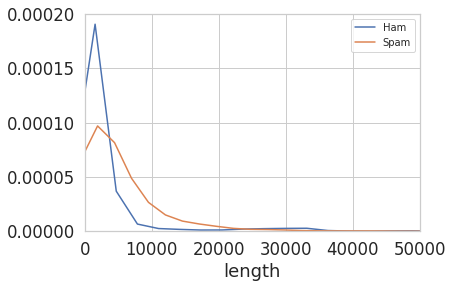

In [15]:
emp_email =[]
for i in train['email']:
    emp_email.append(len(i))
train['length'] = emp_email
train

sns.distplot(train[train['spam']==0]['length'],hist=False, label='Ham')
sns.distplot(train[train['spam']==1]['length'],hist=False, label='Spam')

plt.xlim(0, 50000)
plt.legend(prop={'size': 10})

# Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!



`X_train` should be a matrix of 0s and 1s created by using your `words_in_texts` function on all the emails in the training set.

`Y_train` should be a vector of the correct labels for each email in the training set.



In [16]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = pd.DataFrame(words_in_texts(some_words, train['email']))
Y_train = train['spam']

X_train[:5], Y_train[:5]

(   0  1  2  3  4
 0  0  0  0  0  0
 1  0  0  0  0  0
 2  0  0  0  0  0
 3  0  0  0  0  0
 4  0  0  0  1  0, 7657    0
 6911    0
 6074    0
 4376    0
 5766    0
 Name: spam, dtype: int64)


Now we have matrices we can give to scikit-learn! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, we train a logistic regression model using `X_train` and `Y_train`. Then, output the accuracy of the model (on the training data) in the cell below. 

In [18]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train,Y_train)
y_predict = model.predict(X_train)

from sklearn.metrics import accuracy_score
training_accuracy = accuracy_score(Y_train, y_predict)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


## Evaluating Classifiers


- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

In [20]:
zero_predictor_fp = 0
zero_predictor_fn = 1918

In [22]:
zero_predictor_acc = 5595/len(train)
zero_predictor_recall = 0

FP: Since all the values are predicted as 0, it means that the model observes no spam emails. Therefore there are no false positives.

FN: There are 1918 spam emails. Since none of them are predicted as spam, there are 1918 emails that are wrongly predicted as ham and hence there are 1918 false negatives

Accuracy: The accuracy is the just the number of correct predictions made. In this case because there were 1918 predictions which were correct, the accuracy is the total number of correct predictions - the wrong predictions divided by the total number of predictions.

Recall: Since there are no predictions made as true positive or Spam the recall or true positives is zero.


Compute the precision, recall, and false-alarm rate of the `LogisticRegression` classifier created and trained in Question 5. 

In [24]:
logistic_predictor_precision= 219/(122+219) 
logistic_predictor_recall= 219/(1699+219)
logistic_predictor_far= 122/(5473+122)

There are more False Negatives than False Positives when using the logistic regression classifier.

1. The logistic regression model does have only a slightly higher accuracy than the base model. However there might be other metrics that render the log reg model much more effective as compared to the base model. 

2. The words that were given as features were not necessarily the most frequent words in the dataset. It is also worth considering that since we are identifying spam emails, the features/words that we choose should be very prevalent in the spam emails. 

3. Of these two classifiers I still believe that for this problem statement the base model is a better choice since the log reg model has a very high false positive rate. Important emails might be classified as spam and hence people might miss out on important information such as deadlines, etc.

# Part II - Moving Forward

With this in mind, it is now your task to make the spam filter more accurate. 

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!' were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.



In [26]:
import re

train.isna().sum()

id         0
subject    0
email      0
spam       0
length     0
dtype: int64

In [27]:
train.head()

,id,subject,email,spam,length
7657,7657,Subject: Patch to enable/disable log\n,"while i was playing with the past issues, it a...",0,1641
6911,6911,Subject: When an engineer flaps his wings\n,url: http://diveintomark.org/archives/2002/10/...,0,4713
6074,6074,Subject: Re: [Razor-users] razor plugins for m...,"no, please post a link!\n \n fox\n ----- origi...",0,1399
4376,4376,Subject: NYTimes.com Article: Stop Those Press...,this article from nytimes.com \n has been sent...,0,4435
5766,5766,Subject: What's facing FBI's new CIO? (Tech Up...,<html>\n <head>\n <title>tech update today</ti...,0,32857


In [28]:
# Number of characters in each email


train['str_len_email'] = train['email'].str.len()
train['str_len_subject'] = train['subject'].str.len()

train.isna().sum()

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


id                 0
subject            0
email              0
spam               0
length             0
str_len_email      0
str_len_subject    0
dtype: int64

In [29]:
# Number of words in each email


train['word_len_email'] = train['email'].apply(lambda x: len(str(x).split(" ")))
train['word_len_subject'] = train['subject'].apply(lambda x: len(str(x).split(" ")))
train.isna().sum()

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


id                  0
subject             0
email               0
spam                0
length              0
str_len_email       0
str_len_subject     0
word_len_email      0
word_len_subject    0
dtype: int64

In [30]:
# Use of punctuation (e.g., how many '!' were there?)

def count(char,ser):
    
    x=[]
    for i in ser:
        x.append(len(re.findall(char,i)))
    
    return x

train['punct'] = count('!',train['subject'])
train.isna().sum()

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


id                  0
subject             0
email               0
spam                0
length              0
str_len_email       0
str_len_subject     0
word_len_email      0
word_len_subject    0
punct               0
dtype: int64

In [31]:
# Number / percentage of capital letters

train['upper_email'] = train['email'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
train['upper_subject'] = train['email'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
train.isna().sum()

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


id                  0
subject             0
email               0
spam                0
length              0
str_len_email       0
str_len_subject     0
word_len_email      0
word_len_subject    0
punct               0
upper_email         0
upper_subject       0
dtype: int64

In [32]:
# Count total number of HTML tags

def html_count(string):
    x = []
    for i in string:
        x.append(len(re.findall(r'<,{0,1000}>',i)))
    
    return x

train['html_count'] = html_count(train['email'])
train.isna().sum()

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


id                  0
subject             0
email               0
spam                0
length              0
str_len_email       0
str_len_subject     0
word_len_email      0
word_len_subject    0
punct               0
upper_email         0
upper_subject       0
html_count          0
dtype: int64

In [33]:
train.head()

,id,subject,email,spam,length,str_len_email,str_len_subject,word_len_email,word_len_subject,punct,upper_email,upper_subject,html_count
7657,7657,Subject: Patch to enable/disable log\n,"while i was playing with the past issues, it a...",0,1641,1641,37,309,5,0,0,0,0
6911,6911,Subject: When an engineer flaps his wings\n,url: http://diveintomark.org/archives/2002/10/...,0,4713,4713,42,685,7,0,0,0,0
6074,6074,Subject: Re: [Razor-users] razor plugins for m...,"no, please post a link!\n \n fox\n ----- origi...",0,1399,1399,54,171,7,0,0,0,0
4376,4376,Subject: NYTimes.com Article: Stop Those Press...,this article from nytimes.com \n has been sent...,0,4435,4435,73,746,10,1,0,0,0
5766,5766,Subject: What's facing FBI's new CIO? (Tech Up...,<html>\n <head>\n <title>tech update today</ti...,0,32857,32857,52,3458,8,0,0,0,0


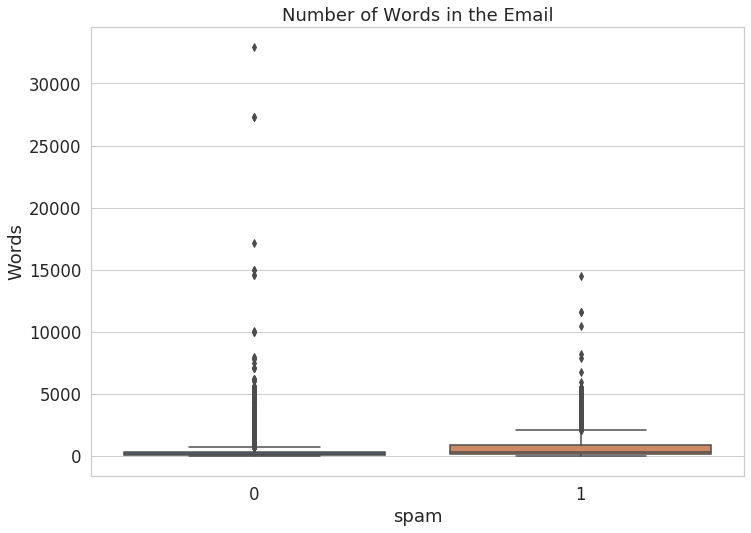

In [34]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27



sns.boxplot( x=train.spam, y=train.word_len_email)
plt.ylabel('Words')
plt.title('Number of Words in the Email');

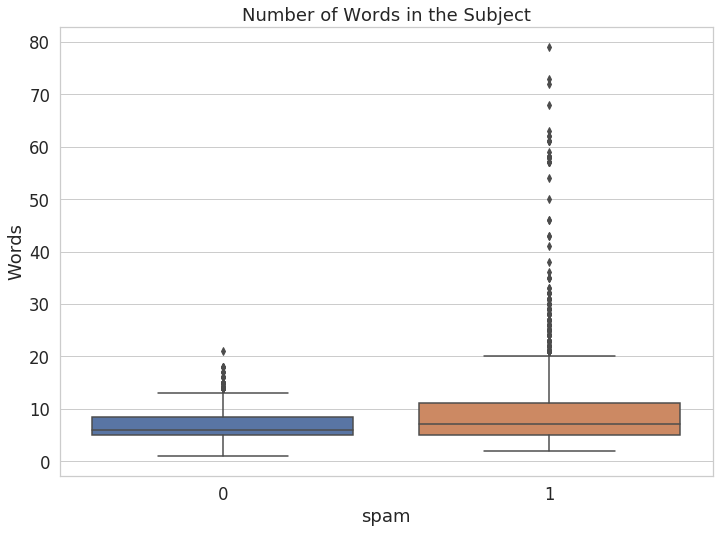

In [35]:
sns.boxplot( x=train.spam, y=train.word_len_subject)
plt.ylabel('Words')
plt.title('Number of Words in the Subject');

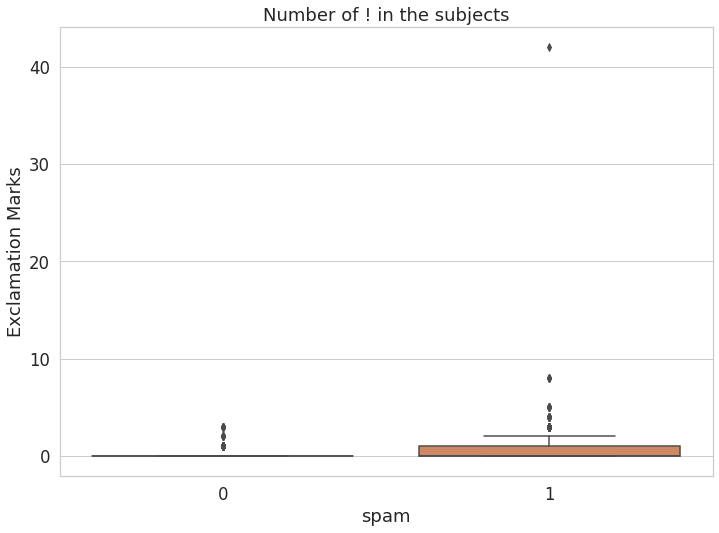

In [36]:
sns.boxplot( x=train.spam, y=train.punct)
plt.ylabel('Exclamation Marks')
plt.title('Number of ! in the subjects');

In [37]:
# Finding better words to use as features. 

# Let us look at the most frequent words in Spam as well as Ham emails

freq_spam = pd.Series(' '.join(train[train['spam']==1]['email']).split()).value_counts()[:]
freq_ham = pd.Series(' '.join(train[train['spam']==0]['email']).split()).value_counts()[:]

# The most common words are often articles like 'a', 'the', or other useless words like stopping words. 
# Therefore we shall look at some of the less common words. 


In [38]:
bagofwords =['protect', 'free', 'receive', 'people', 'click', 'best', 'wish','program', 
              'million', 'credit', 'company', 'marketing', 'special',
              'insurance', 'service', 'grants', 'investment', 'rates', 'body',
              'business', 'html', 'money', 'offer', 'please','tag_count',"i've",
              'me','find','our','file','if','response','can','need','address','option','email',
              'just','send','make','information','time','order','mailing','removed','message',
              'message','because','internet','million','government','they','he','his','do',
              'get','which','use','any','who','mail','now']

# The above list of words was selected from the common words in both the spam and ham emails.
# These were also the most occuring words in text. However their relative frequency is varried.
# The word list is converted to features
type(bagofwords)

list

In [39]:
check = train
check.head()

,id,subject,email,spam,length,str_len_email,str_len_subject,word_len_email,word_len_subject,punct,upper_email,upper_subject,html_count
7657,7657,Subject: Patch to enable/disable log\n,"while i was playing with the past issues, it a...",0,1641,1641,37,309,5,0,0,0,0
6911,6911,Subject: When an engineer flaps his wings\n,url: http://diveintomark.org/archives/2002/10/...,0,4713,4713,42,685,7,0,0,0,0
6074,6074,Subject: Re: [Razor-users] razor plugins for m...,"no, please post a link!\n \n fox\n ----- origi...",0,1399,1399,54,171,7,0,0,0,0
4376,4376,Subject: NYTimes.com Article: Stop Those Press...,this article from nytimes.com \n has been sent...,0,4435,4435,73,746,10,1,0,0,0
5766,5766,Subject: What's facing FBI's new CIO? (Tech Up...,<html>\n <head>\n <title>tech update today</ti...,0,32857,32857,52,3458,8,0,0,0,0


In [40]:
check.isna().sum()

id                  0
subject             0
email               0
spam                0
length              0
str_len_email       0
str_len_subject     0
word_len_email      0
word_len_subject    0
punct               0
upper_email         0
upper_subject       0
html_count          0
dtype: int64

In [41]:
check.shape

(7513, 13)

In [42]:
temp = words_in_texts(bagofwords, check['email'])
temp1 = pd.DataFrame(temp,columns=bagofwords)
temp1.head()


,protect,free,receive,people,click,best,wish,program,million,credit,...,he,his,do,get,which,use,any,who,mail,now
0,0,1,0,0,0,0,0,0,0,0,...,1,0,1,1,1,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,1
2,0,1,0,0,0,0,0,0,0,0,...,1,1,0,1,0,1,1,0,1,0
3,0,0,0,0,0,0,0,1,0,0,...,1,1,1,0,1,1,1,1,1,1
4,1,1,0,1,1,1,1,0,0,0,...,1,1,1,1,1,0,1,0,1,1


In [43]:
temp1.shape

(7513, 62)

In [44]:
check=check.reset_index()
check

,index,id,subject,email,spam,length,str_len_email,str_len_subject,word_len_email,word_len_subject,punct,upper_email,upper_subject,html_count
0,7657,7657,Subject: Patch to enable/disable log\n,"while i was playing with the past issues, it a...",0,1641,1641,37,309,5,0,0,0,0
1,6911,6911,Subject: When an engineer flaps his wings\n,url: http://diveintomark.org/archives/2002/10/...,0,4713,4713,42,685,7,0,0,0,0
2,6074,6074,Subject: Re: [Razor-users] razor plugins for m...,"no, please post a link!\n \n fox\n ----- origi...",0,1399,1399,54,171,7,0,0,0,0
3,4376,4376,Subject: NYTimes.com Article: Stop Those Press...,this article from nytimes.com \n has been sent...,0,4435,4435,73,746,10,1,0,0,0
4,5766,5766,Subject: What's facing FBI's new CIO? (Tech Up...,<html>\n <head>\n <title>tech update today</ti...,0,32857,32857,52,3458,8,0,0,0,0
5,5247,5247,Subject: asap\n,--===_secatt_000_1fuklemuttfusq\n content-type...,1,1156,1156,14,144,2,0,0,0,0
6,7410,7410,Subject: [use Perl] Headlines for 2002-09-18\n,use perl daily headline mailer\n \n subscribe ...,0,631,631,45,98,6,0,0,0,0
7,576,576,"Subject: Cost price Guinness, Budweiser and se...",------=_part_2067_1947928.1038245405702\n cont...,0,26233,26233,73,2166,10,0,0,0,0
8,4398,4398,Subject: Play by Play: Effective Memory Manage...,"url: http://www.newsisfree.com/click/-0,861367...",0,513,513,51,83,7,0,0,0,0
9,3989,3989,Subject: Sheila Lennon was interviewed for the...,url: http://scriptingnews.userland.com/backiss...,0,215,215,60,23,9,0,0,0,0


In [45]:
t = pd.concat([check, temp1], axis = 1)
t.head()

,index,id,subject,email,spam,length,str_len_email,str_len_subject,word_len_email,word_len_subject,...,he,his,do,get,which,use,any,who,mail,now
0,7657,7657,Subject: Patch to enable/disable log\n,"while i was playing with the past issues, it a...",0,1641,1641,37,309,5,...,1,0,1,1,1,0,0,0,1,0
1,6911,6911,Subject: When an engineer flaps his wings\n,url: http://diveintomark.org/archives/2002/10/...,0,4713,4713,42,685,7,...,1,1,1,1,1,1,1,1,0,1
2,6074,6074,Subject: Re: [Razor-users] razor plugins for m...,"no, please post a link!\n \n fox\n ----- origi...",0,1399,1399,54,171,7,...,1,1,0,1,0,1,1,0,1,0
3,4376,4376,Subject: NYTimes.com Article: Stop Those Press...,this article from nytimes.com \n has been sent...,0,4435,4435,73,746,10,...,1,1,1,0,1,1,1,1,1,1
4,5766,5766,Subject: What's facing FBI's new CIO? (Tech Up...,<html>\n <head>\n <title>tech update today</ti...,0,32857,32857,52,3458,8,...,1,1,1,1,1,0,1,0,1,1


In [46]:
X_train = t[['str_len_email',
            'str_len_subject',
            'word_len_email',
            'word_len_subject',
            'punct',
            'upper_email',
            'upper_subject',
            'html_count',
            'protect', 
            'free',
            'receive', 
            'people', 
            'click', 
            'best', 
            'wish',
            'program',
            'million', 
            'credit', 
            'company', 
            'marketing', 
            'special',
            'insurance',
            'service', 
            'grants', 
            'investment', 
            'rates', 
            'body',
            'business', 
            'html', 
            'money', 
            'offer', 
            'please',
            'me',
            'find',
            'our',
            'file',
            'if',
            'response',
            'can',
            'need',
            'address',
            'option',
            'just',
            'send',
            'make',
            'information',
            'time',
            'order',
            'mailing',
            'removed',
            'message',
            'because',
            'internet',
            'million',
            'government',
            'they',
            'he',
            'his',
            'do',
            'get',
            'which',
            'use',
            'any',
            'who',
            'mail']]
X_train.isna().sum()

str_len_email       0
str_len_subject     0
word_len_email      0
word_len_subject    0
punct               0
upper_email         0
upper_subject       0
html_count          0
protect             0
free                0
receive             0
people              0
click               0
best                0
wish                0
program             0
million             0
million             0
credit              0
company             0
marketing           0
special             0
insurance           0
service             0
grants              0
investment          0
rates               0
body                0
business            0
html                0
                   ..
response            0
can                 0
need                0
address             0
option              0
just                0
send                0
make                0
information         0
time                0
order               0
mailing             0
removed             0
message             0
message   

In [47]:
Y_train = train['spam']

In [48]:
model.fit(X_train,Y_train)
y_predict=model.predict(X_train)

from sklearn.metrics import accuracy_score
training_accuracy = accuracy_score(Y_train, y_predict)
print("Training Accuracy: ", training_accuracy)


Training Accuracy:  0.918408092639425


In [49]:
# Function for Feature Engineering

def final_model(train):
    import re
    
    train.fillna('', inplace = True)
    
    # Number of characters in the subject / body
    train['str_len_email'] = train['email'].str.len()
    train['str_len_subject'] = train['subject'].str.len()
    
    # Number of words in the subject / body
    train['word_len_email'] = train['email'].apply(lambda x: len(str(x).split(" ")))
    train['word_len_subject'] = train['subject'].apply(lambda x: len(str(x).split(" ")))
    
    # Use of punctuation (e.g., how many '!' were there?)
    def count(char,ser):
        x=[]
        for i in ser:
            x.append(len(re.findall(char,i)))
            
        return x
    
    train['punct'] = count('!',train['subject'])
    
    # Number / percentage of capital letters
    train['upper_email'] = train['email'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
    train['upper_subject'] = train['email'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
    
    # Count total number of HTML tags
    def html_count(string):
        x = []
        for i in string:
            x.append(len(re.findall(r'<,{0,1000}>',i)))
            
        return x
    train['html_count'] = html_count(train['email'])
    
    
    bagofwords =['protect', 'free', 'receive', 'people', 'click', 'best', 'wish','program', 
              'million', 'credit', 'company', 'marketing', 'special',
              'insurance', 'service', 'grants', 'investment', 'rates', 'body',
              'business', 'html', 'money', 'offer', 'please','tag_count',"i've",
              'me','find','our','file','if','response','can','need','address','option','email',
              'just','send','make','information','time','order','mailing','removed','message',
              'message','because','internet','million','government','they','he','his','do',
              'get','which','use','any','who','mail','now']
    # The above list of words was selected from the common words in both the spam and ham emails.
    # These were also the most occuring words in text. However their relative frequency is varried.
    # The word list is converted to features
    
    def words_in_texts(words, texts):
        '''
        Args:words (list-like): words to find texts (Series): strings to search in
        Returns: NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
        '''
        x = []
        for j in texts:
            bag_vector = []
            for w in words:
                bag_vector.append(int(w in j))
            x.append(bag_vector)
            
        indicator_array = np.array(x)
        return indicator_array
    
    check = train
    
    temp = words_in_texts(bagofwords, check['email'])
    temp1 = pd.DataFrame(temp,columns=bagofwords)
    temp1.head()
    
    check = check.reset_index()
    
    t = pd.concat([check, temp1], axis = 1)
    
    X_train = t[['str_len_email',
            'str_len_subject',
            'word_len_email',
            'word_len_subject',
            'punct',
            'upper_email',
            'upper_subject',
            'html_count',
            'protect', 
            'free',
            'receive', 
            'people', 
            'click', 
            'best', 
            'wish',
            'program',
            'million', 
            'credit', 
            'company', 
            'marketing', 
            'special',
            'insurance',
            'service', 
            'grants', 
            'investment', 
            'rates', 
            'body',
            'business', 
            'html', 
            'money', 
            'offer', 
            'please',
            'me',
            'find',
            'our',
            'file',
            'if',
            'response',
            'can',
            'need',
            'address',
            'option',
            'just',
            'send',
            'make',
            'information',
            'time',
            'order',
            'mailing',
            'removed',
            'message',
            'because',
            'internet',
            'million',
            'government',
            'they',
            'he',
            'his',
            'do',
            'get',
            'which',
            'use',
            'any',
            'who',
            'mail']]
    X_test = X_train
    
    y = train['spam']
    
    return X_test, y
    
    

In [50]:
X_val, y_val = final_model(val)

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [51]:
y_val_predict = model.predict(X_val)

1. By understanding the relationship between several features intrinsically I could find words that would make more sense to contribute to decididng whether something would be spam or not. For the words the decision of including them was based on their frequency in all the emails as well as their frequency in the spam emails as that is what we were trying to identify.

2. What worked was all the added features and adding more and more words. What did not work was the feature of emails with an re always being ham. As there were some emails with an re which were also spam. The length of the emails, the length of the subjects all additionally useful features. 

3. Maybe the fact the re emails were also spam was a bit surprising.

### EDA



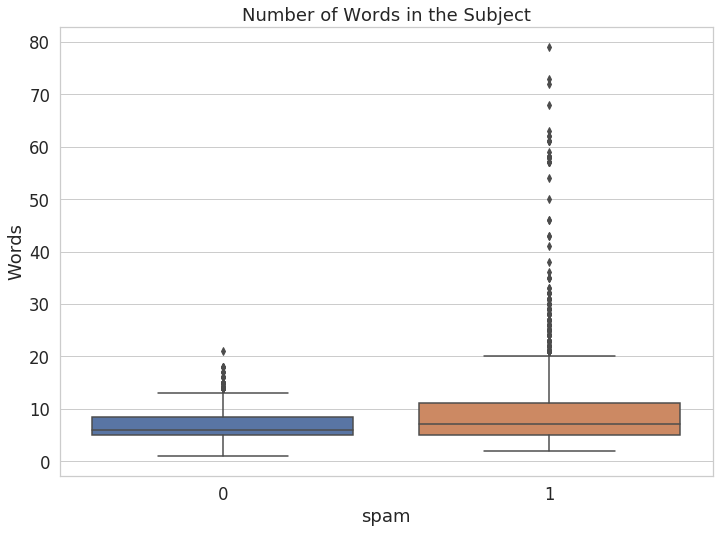

In [52]:
# The number of words in the subject and email of spam is clearly higher than that of ham emails.

sns.boxplot( x=train.spam, y=train.word_len_subject)
plt.ylabel('Words')
plt.title('Number of Words in the Subject');

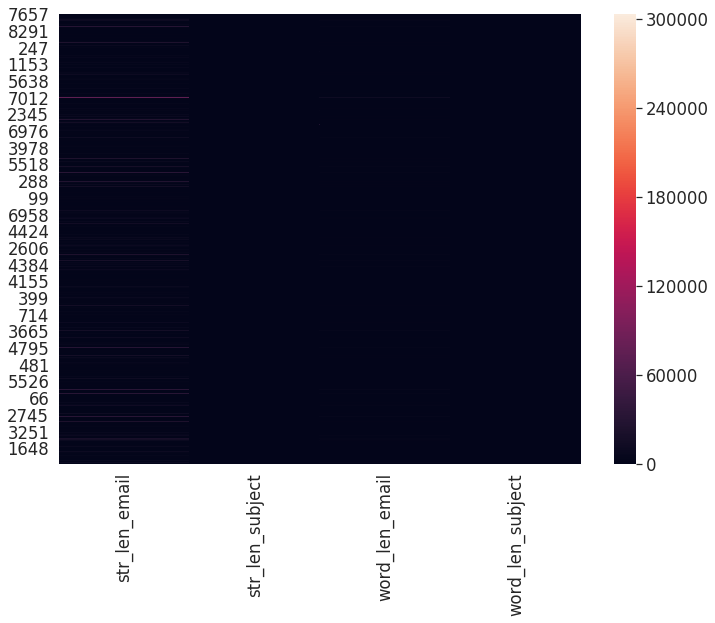

In [53]:
sns.heatmap(train[['str_len_email','str_len_subject','word_len_email','word_len_subject']])

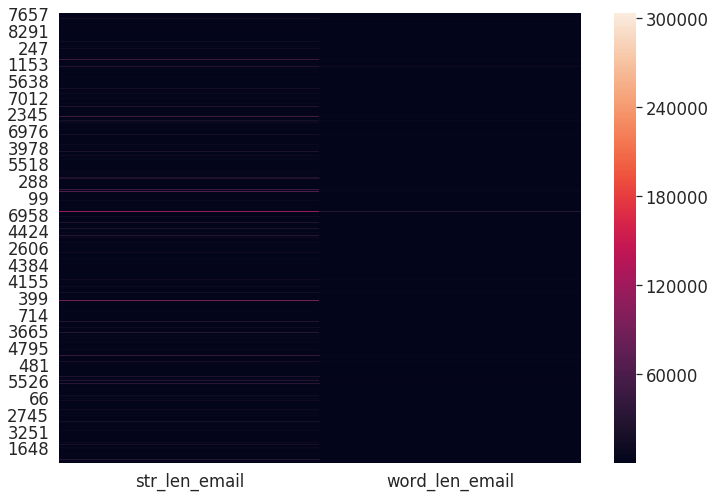

In [54]:
sns.heatmap(train[['str_len_email','word_len_email']])

### Precision-Recall Curve



In [55]:
from sklearn.metrics import precision_recall_curve

# Note that you'll want to use the .predict_proba(...) method for your classifier
# instead of .predict(...) so you get probabilities, not classes

yy = model.predict_proba(X_val)
y_prob = []
for i in yy:
    y_prob.append(i[0])

y_val_predict=np.array(y_prob)
y_val_predict

array([9.24284738e-01, 9.43995051e-01, 9.97690412e-01, 9.77729697e-01,
       8.07745592e-01, 9.94972830e-01, 1.61050914e-01, 1.10214421e-01,
       7.77797342e-02, 9.54705856e-01, 8.65303648e-01, 9.53381610e-01,
       9.79997143e-01, 9.93706467e-01, 1.86213468e-01, 3.05950148e-02,
       1.44414631e-02, 8.06915342e-03, 9.58637035e-01, 7.81304948e-01,
       9.52621192e-01, 8.77852221e-01, 8.96278942e-01, 9.56143922e-01,
       2.80667797e-02, 9.50019679e-01, 6.55494873e-01, 1.54621838e-01,
       9.92771353e-01, 9.78475663e-01, 5.36685229e-02, 9.95696924e-01,
       9.44022040e-01, 6.47226669e-01, 9.98221227e-01, 4.81679489e-02,
       6.89032606e-01, 9.62966151e-01, 1.57167404e-05, 9.96731208e-01,
       9.89698356e-01, 5.33979272e-02, 9.19443048e-01, 9.81989364e-01,
       8.50789792e-01, 9.84062472e-01, 9.97723998e-01, 3.23573619e-01,
       4.23070017e-01, 1.38851463e-02, 1.51497902e-01, 2.15614690e-03,
       8.92502183e-01, 9.77293343e-01, 9.91206528e-01, 9.42874443e-01,
      

Average precision-recall score: 0.15


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.15')

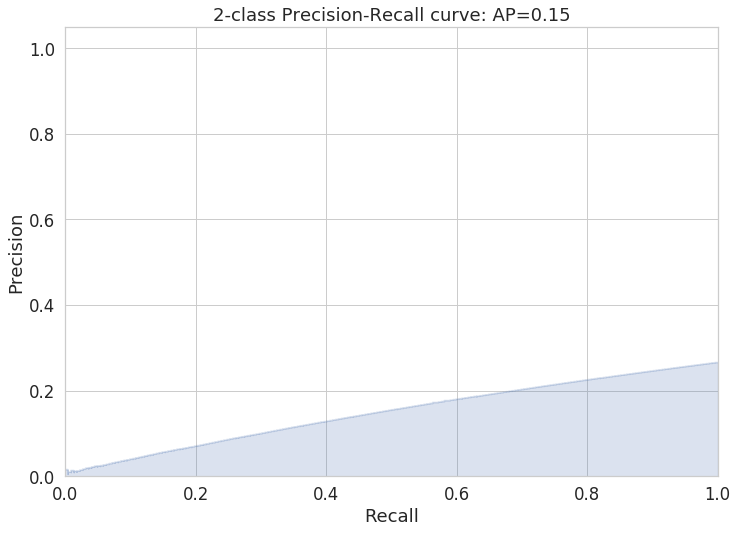

In [56]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(y_val,y_val_predict)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
precision, recall, _ = precision_recall_curve(y_val, y_val_predict)


# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))


# Production ETL



In [57]:
def final_model(train):
    import re
    
    train.fillna('', inplace = True)
    
    # Number of characters in the subject / body
    train['str_len_email'] = train['email'].str.len()
    train['str_len_subject'] = train['subject'].str.len()
    
    # Number of words in the subject / body
    train['word_len_email'] = train['email'].apply(lambda x: len(str(x).split(" ")))
    train['word_len_subject'] = train['subject'].apply(lambda x: len(str(x).split(" ")))
    
    # Use of punctuation (e.g., how many '!' were there?)
    def count(char,ser):
        x=[]
        for i in ser:
            x.append(len(re.findall(char,i)))
            
        return x
    
    train['punct'] = count('!',train['subject'])
    
    # Number / percentage of capital letters
    train['upper_email'] = train['email'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
    train['upper_subject'] = train['email'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
    
    # Count total number of HTML tags
    def html_count(string):
        x = []
        for i in string:
            x.append(len(re.findall(r'<,{0,1000}>',i)))
            
        return x
    train['html_count'] = html_count(train['email'])
    
    
    bagofwords =['protect', 'free', 'receive', 'people', 'click', 'best', 'wish','program', 
              'million', 'credit', 'company', 'marketing', 'special',
              'insurance', 'service', 'grants', 'investment', 'rates', 'body',
              'business', 'html', 'money', 'offer', 'please','tag_count',"i've",
              'me','find','our','file','if','response','can','need','address','option','email',
              'just','send','make','information','time','order','mailing','removed','message',
              'message','because','internet','million','government','they','he','his','do',
              'get','which','use','any','who','mail','now']
    # The above list of words was selected from the common words in both the spam and ham emails.
    # These were also the most occuring words in text. However their relative frequency is varried.
    # The word list is converted to features
    
    def words_in_texts(words, texts):
        '''
        Args:words (list-like): words to find texts (Series): strings to search in
        Returns: NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
        '''
        x = []
        for j in texts:
            bag_vector = []
            for w in words:
                bag_vector.append(int(w in j))
            x.append(bag_vector)
            
        indicator_array = np.array(x)
        return indicator_array
    
    check = train
    
    temp = words_in_texts(bagofwords, check['email'])
    temp1 = pd.DataFrame(temp,columns=bagofwords)
    temp1.head()
    
    check = check.reset_index()
    
    t = pd.concat([check, temp1], axis = 1)
    
    X_train = t[['str_len_email',
            'str_len_subject',
            'word_len_email',
            'word_len_subject',
            'punct',
            'upper_email',
            'upper_subject',
            'html_count',
            'protect', 
            'free',
            'receive', 
            'people', 
            'click', 
            'best', 
            'wish',
            'program',
            'million', 
            'credit', 
            'company', 
            'marketing', 
            'special',
            'insurance',
            'service', 
            'grants', 
            'investment', 
            'rates', 
            'body',
            'business', 
            'html', 
            'money', 
            'offer', 
            'please',
            'me',
            'find',
            'our',
            'file',
            'if',
            'response',
            'can',
            'need',
            'address',
            'option',
            'just',
            'send',
            'make',
            'information',
            'time',
            'order',
            'mailing',
            'removed',
            'message',
            'because',
            'internet',
            'million',
            'government',
            'they',
            'he',
            'his',
            'do',
            'get',
            'which',
            'use',
            'any',
            'who',
            'mail']]
    X_test = X_train
    
    return X_test
    
    
    
    
    

In [58]:
X_test = final_model(test)

In [59]:
test_predictions = model.predict(X_test)

The following saves a file to submit to Kaggle.

In [61]:
from datetime import datetime

# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Kaggle for scoring.')

Created a CSV file: submission_2019-08-10T14:01:34.csv.
You may now upload this CSV file to Kaggle for scoring.
